# Download and Unzip Dataset 

In [ ]:
import zipfile

In [ ]:
#with zipfile.ZipFile('running-20240520T181542Z-001.zip', 'r') as zip_ref:
    #zip_ref.extractall('Capstone project')


#unzip files individual files into a folder named Capstone project

In [ ]:
#with zipfile.ZipFile('run.zip', 'r') as zip_ref:
    #zip_ref.extractall('Capstone project')


# Import Required Libraries

In [ ]:
!pip install pafy youtube-dl moviepy

In [ ]:
!pip install moviepy


#below code turns the mp4 to avi 

In [ ]:
#import os
#from moviepy.editor import VideoFileClip

#def convert_mp4_to_avi(input_path, output_path):
    # Load the mp4 file
   # clip = VideoFileClip(input_path)
    
    # Write the video to an avi file
    #clip.write_videofile(output_path, codec='png')
    
    # Close the clip
    #clip.close()

#def convert_all_videos_in_folder(input_folder, output_folder):
    # Ensure the output folder exists
    #os.makedirs(output_folder, exist_ok=True)
    
    # Iterate through all files in the input folder
    #for filename in os.listdir(input_folder):
       # if filename.endswith('.mp4'):
           # input_path = os.path.join(input_folder, filename)
           # output_filename = os.path.splitext(filename)[0] + '.avi'
            #output_path = os.path.join(output_folder, output_filename)
           # convert_mp4_to_avi(input_path, output_path)
           # print(f'Converted {input_path} to {output_path}')

# Define the input and output folders
#input_folder = 'Dataset/Fighting'
#output_folder = 'converted_to_avi'

# Convert all videos in the input folder
#convert_all_videos_in_folder(input_folder, output_folder)

In [1]:
!pip install opencv-python


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
!pip install numpy==1.22.1


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
!pip install tensorflow==2.13.0


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
pip install --upgrade h5py


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [5]:
import os
import cv2
import pafy
import math
import numpy as np
import random
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Select Randomness

In [6]:
seed_constant = 5
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# View the dataset

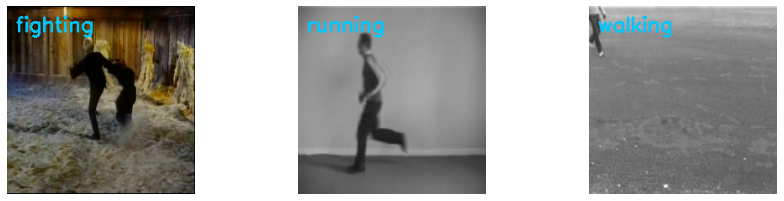

In [7]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# Update the path to your dataset directory
dataset_directory = 'Dataset'

# View the dataset
plt.figure(figsize=(20, 20))

# List all class directories
all_classes_names = os.listdir(dataset_directory)

for counter, class_name in enumerate(all_classes_names, 1):
    # List all video files in the current class directory
    class_path = os.path.join(dataset_directory, class_name)
    video_files_names_list = os.listdir(class_path)
    
    if not video_files_names_list:
        continue  # Skip if no video files in the class directory
    
    # Select a random video file from the current class
    selected_video_file_name = random.choice(video_files_names_list)
    video_path = os.path.join(class_path, selected_video_file_name)
    
    # Read a frame from the selected video
    video_reader = cv2.VideoCapture(video_path)
    video_reader.set(1, 25)  # Set to read the 25th frame
    success, bgr_frame = video_reader.read()
    video_reader.release()
    
    if not success:
        continue  # Skip if unable to read the frame
    
    # Resize and convert frame to RGB
    bgr_frame = cv2.resize(bgr_frame, (224, 224))
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    
    # Put class name text on the frame
    cv2.putText(rgb_frame, class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 200, 255), 2)
    
    # Display the frame
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

plt.show()


# Set Dataset Variables

In [8]:
# Set Dataset Variables
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 30
DATASET_DIR = "Dataset"
CLASSES_LIST = ["walking", "fighting", "running"]

# Data pre-processing

In [9]:

# Frame extraction function
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list


In [10]:
# Dataset creation function
def create_dataset():
    features = []
    labels = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels

In [11]:
# Load dataset
features, labels = create_dataset()

Extracting Data of Class: walking
Extracting Data of Class: fighting
Extracting Data of Class: running


In [15]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [ ]:

# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

In [ ]:
# Split the Data into Train (75%) and Test Set (25%)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.25, shuffle=True, random_state=seed_constant)
features = None
labels = None

In [ ]:
!pip install keras-tuner

In [ ]:
# Example: Tuning model with Keras Tuner (simple LRCN model)
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Example: Tuning model with Keras Tuner (simple LRCN model)
def build_model(hp):
    model = Sequential()
    model.add(TimeDistributed(Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=32), 
                                (3, 3), activation='relu'), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(hp.Int('conv2_filters', min_value=32, max_value=128, step=32), 
                                (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(hp.Int('lstm_units', min_value=50, max_value=200, step=50)))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10, executions_per_trial=1)
tuner.search(features, one_hot_encoded_labels, epochs=10, validation_split=0.2, callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
history = best_model.fit(datagen.flow(features, one_hot_encoded_labels, batch_size=32),
                         epochs=50, validation_split=0.2, callbacks=[reduce_lr, early_stopping, model_checkpoint])


# Model Creation LRCN (Long-term Recurrent Convolutional Network)

In [18]:
# Model Creation LRCN (Long-term Recurrent Convolutional Network)
def create_LRCN_model():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()
    return model

In [19]:
# Create the model
model = create_LRCN_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 30, 64, 64, 32)    896       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 30, 16, 16, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 30, 16, 16, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 30, 4, 4, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 30, 4, 4, 128)    

In [24]:
for layer in model.layers:
    print(layer.name, layer.output_shape)


time_distributed (None, 30, 64, 64, 32)
time_distributed_1 (None, 30, 16, 16, 32)
time_distributed_2 (None, 30, 16, 16, 64)
time_distributed_3 (None, 30, 4, 4, 64)
time_distributed_4 (None, 30, 4, 4, 128)
time_distributed_5 (None, 30, 2, 2, 128)
time_distributed_6 (None, 30, 2, 2, 256)
time_distributed_7 (None, 30, 1, 1, 256)
time_distributed_8 (None, 30, 256)
lstm (None, 32)
dense_2 (None, 3)


In [20]:
pip install visualkeras


   ---------------------------------------- 43.2/43.2 kB 162.6 kB/s eta 0:00:00



DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [ ]:
plot_model(model, to_file = 'Suspicious_Human_Activity_LRCN_Model.png', show_shapes = True, show_layer_names = True)

# Model Training

In [28]:
# Model Training
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor='accuracy', patience=10, mode='max', restore_best_weights=True)

# Compile the model and specify loss function, optimizer and metrics to the model.
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

# Start training the model.
model_training_history = model.fit(x=features_train, y=labels_train, epochs=70, batch_size=4, shuffle=True, validation_split=0.25, callbacks=[early_stopping_callback])


Epoch 1/70
44/44 [==============================] - 27s 421ms/step - loss: 0.9190 - accuracy: 0.5657 - val_loss: 0.5424 - val_accuracy: 0.7119
Epoch 2/70
44/44 [==============================] - 17s 384ms/step - loss: 0.5805 - accuracy: 0.6457 - val_loss: 0.5126 - val_accuracy: 0.6610
Epoch 3/70
44/44 [==============================] - 15s 336ms/step - loss: 0.5676 - accuracy: 0.6229 - val_loss: 0.4734 - val_accuracy: 0.6949
Epoch 4/70
44/44 [==============================] - 15s 331ms/step - loss: 0.5091 - accuracy: 0.6286 - val_loss: 0.4919 - val_accuracy: 0.6610
Epoch 5/70
44/44 [==============================] - 14s 328ms/step - loss: 0.4929 - accuracy: 0.6743 - val_loss: 0.4593 - val_accuracy: 0.6780
Epoch 6/70
44/44 [==============================] - 14s 328ms/step - loss: 0.4760 - accuracy: 0.6857 - val_loss: 0.4568 - val_accuracy: 0.6780
Epoch 7/70
44/44 [==============================] - 15s 343ms/step - loss: 0.4767 - accuracy: 0.6743 - val_loss: 0.4516 - val_accuracy: 0.6780

# Save Model

In [29]:
# Save your Model.
model.save("Improved_Suspicious_Human_Activity_Detection_LRCN_Model2.h5")

# Plot Loss and Accuracy Graphs while Training

In [30]:

# Plot Loss and Accuracy Graphs while Training
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()


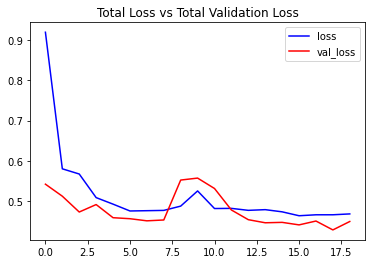

In [31]:
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')


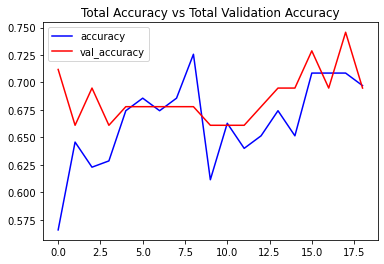

In [32]:
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Accuracy on Test Dataset

In [33]:
# Accuracy on Test Dataset
# Calculate Accuracy On Test Dataset
acc = 0
for i in range(len(features_test)):
    predicted_label = np.argmax(model.predict(np.expand_dims(features_test[i], axis=0))[0])
    actual_label = np.argmax(labels_test[i])
    if predicted_label == actual_label:
        acc += 1
acc = (acc * 100) / len(labels_test)
print("Accuracy =", acc)

1/1 [==============================] - 0s 45ms/step
Accuracy = 64.1025641025641
